In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
import pickle
%load_ext autoreload
%autoreload 2

In [3]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

# traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
# #Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
# traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
# traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
# traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
# traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
# traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
# traveler_trips.orig_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
# value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
# value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
# early_penalty_threshold=pd.read_csv('input/EarlyArrPenaltyThreshold.dat',sep='\t',index_col=0)
# late_penalty_threshold=pd.read_csv('input/LateArrPenaltyThreshold.dat',sep='\t',index_col=0)

# traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'early_penalty_threshold']=traveler_trips.apply(lambda row: early_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'late_penalty_threshold']=traveler_trips.apply(lambda row: late_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.to_csv('input/traveler_trip_info_improved.csv')
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv')
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))

    three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)

drivingcost_per_mile=0.5
# traveler_trips=prd.compare_mode_utlity(traveler_trips,TransitMazTazFlag,
#                         three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
#                         Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
#                         Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)

56 57 72


For different scenario, we want to know the number of
1. trips increased
2. the total travel cost
3. Mode share change

In [14]:
car_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>=1)]
car_trips=car_trips.loc[(car_trips.orig_taz !=car_trips.dest_taz) | (car_trips.trip_counter==1)]
car_transit_trips=car_trips.append(traveler_trips[traveler_trips.tripmode>8])

### Car Trips Only, no shared rides

In [9]:
input_filepath='Output/'
run_name='allhhcartrip1/'
route_info=pd.read_csv(input_filepath+run_name+'route_info.csv',index_col=0)
darp_solution=pod.load_obj('darp_solutions',input_filepath+run_name)

In [57]:
route_info_updated_cost=route_info.apply(lambda x: 
                    prd.estimate_single_car_trip_cost(x.orig_zone,x.dest_zone,x.start_time,
                                                     x.value_of_time,Vehicular_Skim_Dict,0,superzone_map,drivingcost_per_mile),axis=1)

route_info_update_distance=route_info.apply(lambda x:
                    prd.estimate_single_car_trip_cost(x.orig_zone,x.dest_zone,x.start_time,
                                                     x.value_of_time,Vehicular_Skim_Dict,1,superzone_map,drivingcost_per_mile),axis=1)

In [59]:
total_generalized_cost=sum(route_info_updated_cost)+len(route_info_updated_cost)*1.5
total_mile_traveled=sum(route_info_update_distance)

In [60]:
print(total_generalized_cost,total_mile_traveled)

962358.09298 1648572.012


### Car trips only share ride factor 1.25

In [37]:
run_name='allhhcartrip1.25/'
route_info=pd.read_csv(input_filepath+run_name+'route_info.csv',index_col=0)
darp_solution=pod.load_obj('darp_solutions',input_filepath+run_name)

In [38]:
print(datetime.datetime.now())
num_shared_ride_dict={}
total_number_shared_rides=0
for group1, group2 in zip(route_info.groupby(['hh_id']),car_trips.groupby(['hh_id'])):
    temp=group1[1]
    num_shared_ride=len(temp[(temp.orig_node_index<len(group2[1]) &(temp.dest_node_index<len(group2[1])))])
    num_shared_ride_dict[group1[0]]=num_shared_ride
    total_number_shared_rides+=num_shared_ride
print(datetime.datetime.now())

2018-07-17 10:03:54.934510
2018-07-17 10:04:42.857548


In [39]:
num_shared_ride

0

In [25]:
route_info.apply(
        lambda row:prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim_Dict,1,
            superzone_map,drivingcost_per_mile) ,axis=1).sum()

1637274.6999998002

In [32]:
print('Total number of trips',len(route_info))
print('Total number of empty trips',len(route_info[route_info.person_id==0]))

Total number of trips 221986
Total number of empty trips 39575


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hol

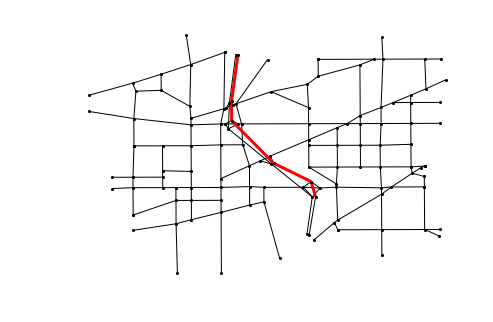

In [81]:
av.trip_chain_highlight([16,9952,9953,10166,10353],[9952,9953,10166,10353,10380],node_detail,link_detail,nodexy) 